In [1]:
import numpy as np

from commons import *
from dataset_loader import load_images, prepare_dataset
from IPython.display import display
import cv2
import pickle
import matplotlib.pyplot as plt
from keras.models import load_model


DOTS_SRC = 'hit-images-final2/dot'
TRACKS_SRC = 'hit-images-final2/line'
WORMS_SRC = 'hit-images-final2/worms'
ARTIFACTS_SRC = 'hit-images-final2/artefact'

DOTS_AC = 'cache/dots_100000.h5'
TRACKS_AC = 'cache/tracks_100000.h5'
WORMS_AC = 'cache/worms_100000.h5'
ARTIFACTS_AC = 'cache/artifacts_100000.h5'


# TODO: trzy klasy do kupy, wyznaczyć threshold. Pamiętać, że teraz liczność będzie 1:3, a nie 1:1
#       i wtedy sprawdzić jak ten próg odróżnia klasy
# TODO: przetestować metrykę samą w sobie dla dwóch obrazków
# TODO: zastosować metrykę KL z VAE w tym kodzie


dots_set =  prepare_dataset(load_images(DOTS_SRC))
worms_set =  prepare_dataset(load_images(WORMS_SRC))
tracks_set =  prepare_dataset(load_images(TRACKS_SRC))
artifacts_set =  prepare_dataset(load_images(ARTIFACTS_SRC))

dots_autoencoder = load_model(DOTS_AC)
worms_autoencoder = load_model(WORMS_AC)
tracks_autoencoder = load_model(TRACKS_AC)
artifacts_autoencoder = load_model(ARTIFACTS_AC)

on = {'dots': calc_similarity(dots_autoencoder, dots_set, tracks_set, worms_set, artifacts_set),
      'worms': calc_similarity(worms_autoencoder, dots_set, tracks_set, worms_set, artifacts_set),
      'tracks': calc_similarity(tracks_autoencoder, dots_set, tracks_set, worms_set, artifacts_set),
      'artifacts': calc_similarity(artifacts_autoencoder, dots_set, tracks_set, worms_set, artifacts_set)}

Channel dots, compare dots vs tracks, threshold: -11.36626514475795, fp/fn percent: 3.54251012145749 %


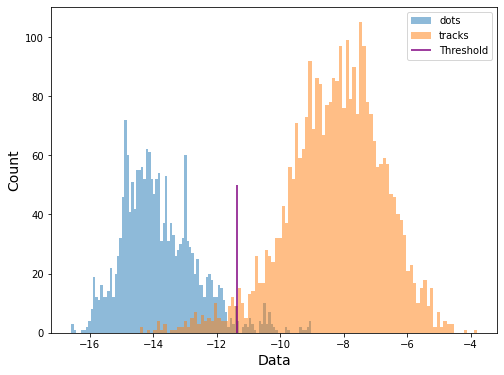

Channel dots, compare dots vs worms, threshold: -10.7884532371908, fp/fn percent: 2.446225221425559 %


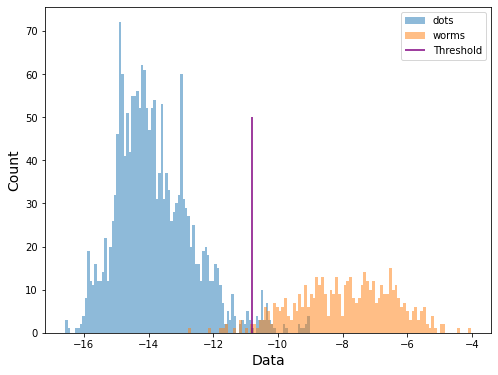

Channel dots, compare dots vs artifacts, threshold: -11.499367830267385, fp/fn percent: 4.165013883379611 %


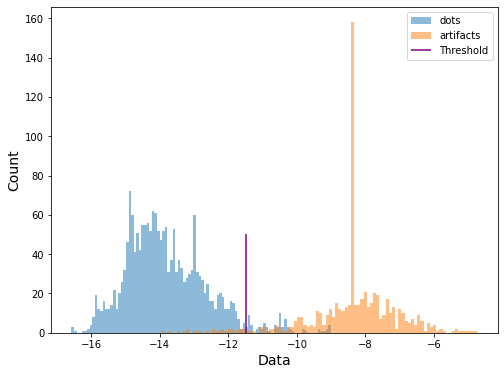

Channel tracks, compare tracks vs dots, threshold: -10.976440146793056, fp/fn percent: 43.54251012145749 %


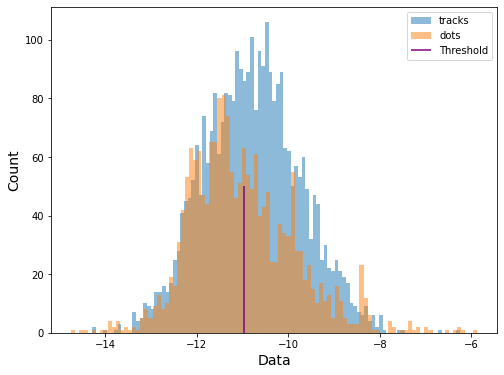

Channel tracks, compare tracks vs worms, threshold: -10.002773577508513, fp/fn percent: 22.15669755686605 %


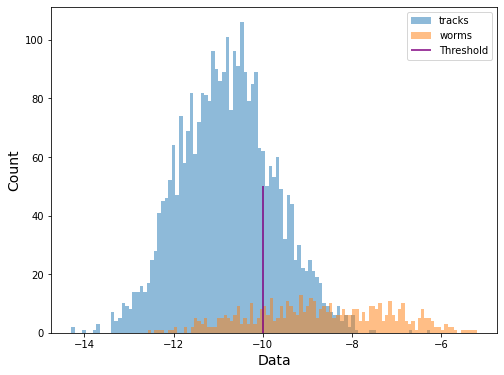

Channel tracks, compare tracks vs artifacts, threshold: -9.703735141002296, fp/fn percent: 15.467528967933172 %


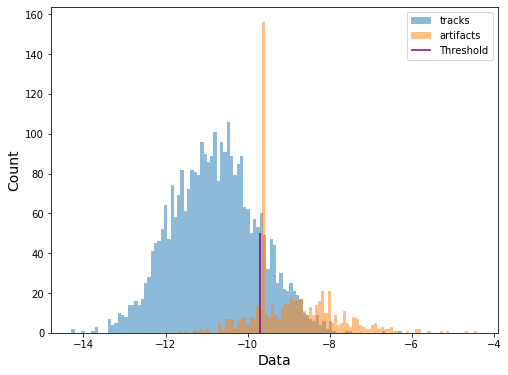

Channel worms, compare worms vs dots, threshold: -9.467717073269498, fp/fn percent: 35.72332349219739 %


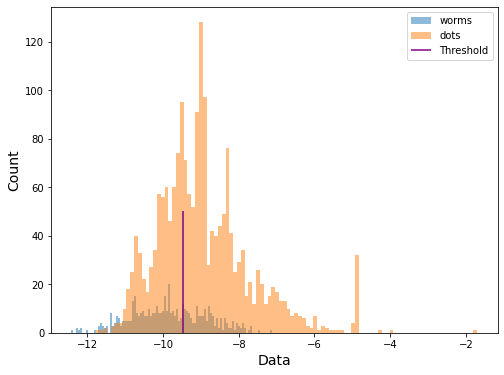

Channel worms, compare worms vs tracks, threshold: -9.425361789380272, fp/fn percent: 34.260039314799215 %


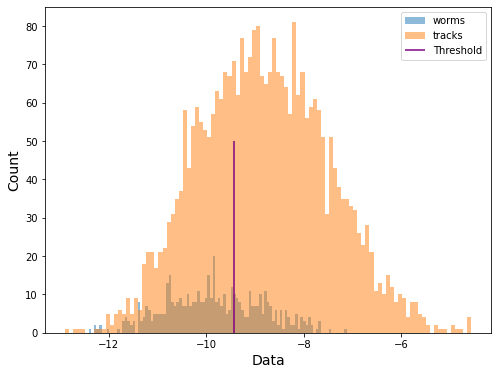

Channel worms, compare worms vs artifacts, threshold: -9.024331727309178, fp/fn percent: 22.942206654991242 %


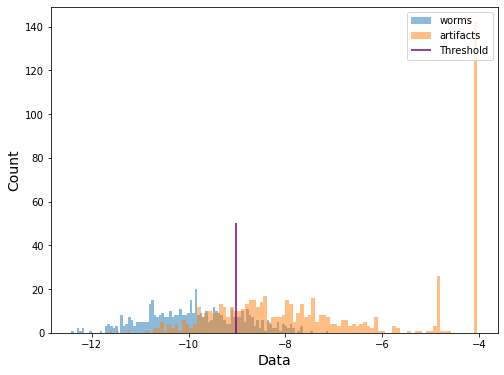

Channel artifacts, compare artifacts vs dots, threshold: -7.308245233909378, fp/fn percent: 45.180483934946444 %


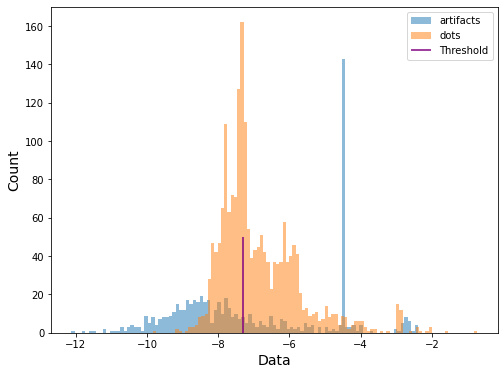

Channel artifacts, compare artifacts vs tracks, threshold: -7.719850558550157, fp/fn percent: 48.585286984640256 %


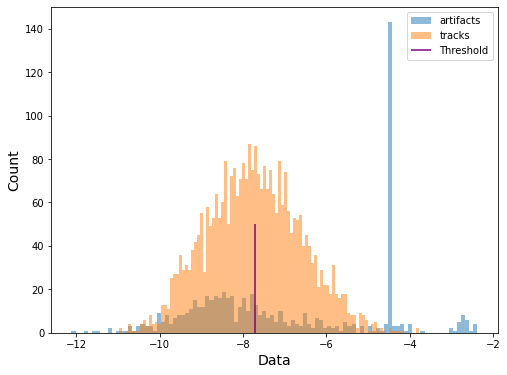

Channel artifacts, compare artifacts vs worms, threshold: -7.6200427640049035, fp/fn percent: 49.299474605954465 %


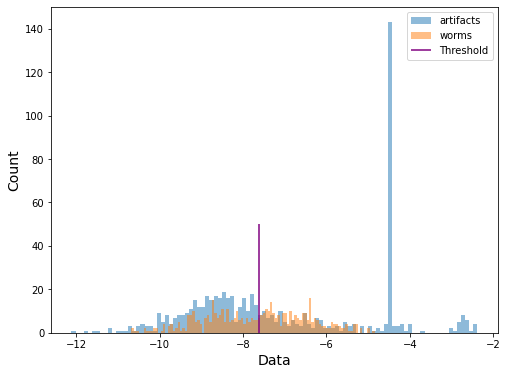

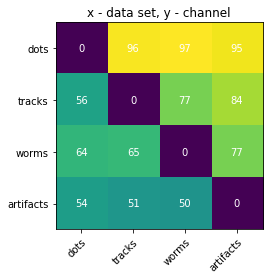

In [2]:
confusion_matrix(on)